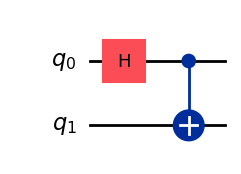

In [1]:
from qiskit import QuantumCircuit

QC = QuantumCircuit(2)

QC.h(0)
QC.cx(0, 1)

QC.draw(output='mpl')

In [2]:
#map problem to operators - make sure everythings working - expectation value- in case of bell state - xx operators - non expectation value 
#XI XZ - 2nd operator - 0 expectations value. 
from qiskit.quantum_info import Pauli 
ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX') 

observables = [ZZ, ZI, IZ, XX, XI, IX]


In [3]:
#step 2: optimize - don't need to map some local activity or - data- simulator - 
#step 3: execute backend
#extentiate air simulator and generate a way of accessing ismular to primitive something
from qiskit_aer.primitives import Estimator 

estimator = Estimator()

job = estimator.run([QC] * len (observables), observables)
#same number of circuits as observables 
#what is job? .estimator
job.result() 

EstimatorResult(values=array([ 1.        , -0.04101562, -0.04101562,  1.        ,  0.06835938,
        0.06835938]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0363682, 'sample_measure_time': 0.0045843, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 16084, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 16, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9983177185058594, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0363682, 'sample_measure_time': 0.0045

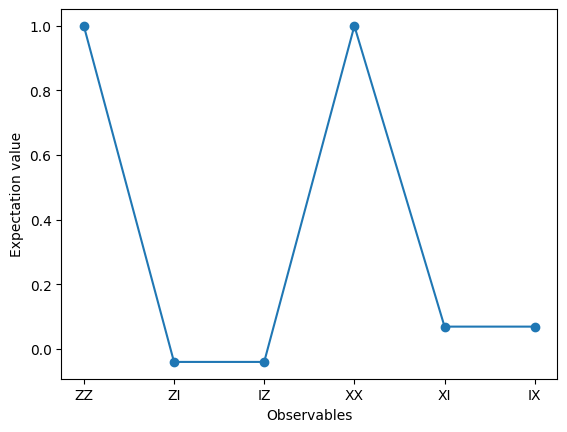

In [4]:
import matplotlib.pyplot as plt

data = ['ZZ', 'ZI', 'IZ', 'XX', 'XI', 'IX']
values = job.result().values

plt.plot(data, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Expectation value')
plt.show()

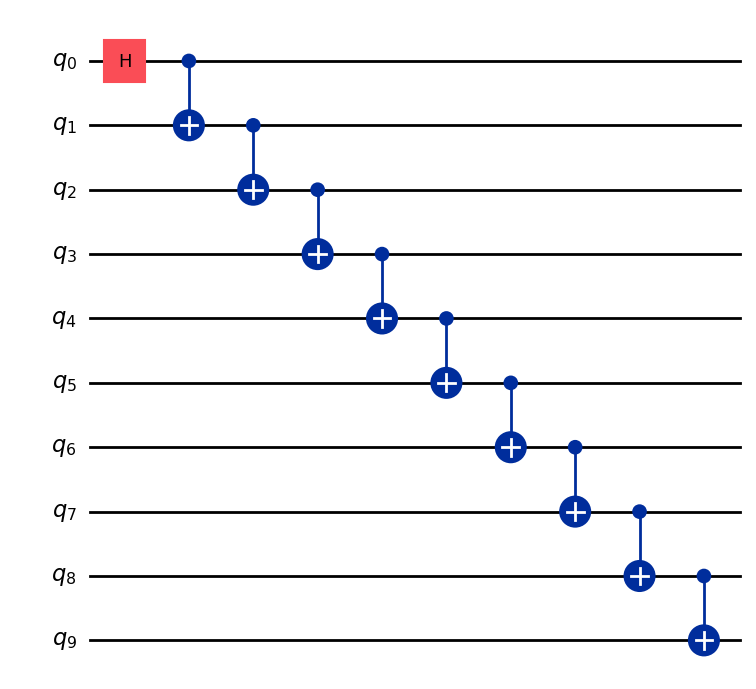

In [5]:
#100 qubit
#extend the hello world example to an n-qubit ghz state 
#step 1: map the problem to circuits and operators 
def get_qc_for_n_qubit_GHZ_state(n):
    QC = QuantumCircuit(n)
    QC.h(0)
    for i in range(n-1):
        QC.cx(i, i+1)
    return QC
n = 10
QC = get_qc_for_n_qubit_GHZ_state(n)
QC.draw(output='mpl')
    

In [6]:
#noise between them? 
#op between qubits 
from qiskit.quantum_info import SparsePauliOp
operator_strings = ['Z' + 'I' * i + 'Z' + 'I' * (n-2-i) for i in range(n-1)]
print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(operator_string) for operator_string in operator_strings]


['ZZIIIIIIII', 'ZIZIIIIIII', 'ZIIZIIIIII', 'ZIIIZIIIII', 'ZIIIIZIIII', 'ZIIIIIZIII', 'ZIIIIIIZII', 'ZIIIIIIIZI', 'ZIIIIIIIIZ']
9


In [10]:
#step 2- optimize problem for execution - quantum exectuion 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
#call backend - how to convert cirtuit that can be executed - 
QiskitRuntimeService.save_account(token="e024yHq_Uq19By-adlGxBdnnD_LZdtuItFPZLFtZRR30", overwrite=True)


backend_name = "ibm_brisbane"
backend = QiskitRuntimeService(instance='QiskitTest').backend(backend_name)
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled = pass_manager.run(QC)
#map circuits w device - just spots around 
operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators] 



In [11]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()
options.resilience_level = 1
#options.optimization_level = 0
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = Estimator(backend, options=options)

job = estimator.run([(qc_transpiled, operators_transpiled_list)])
job_id = job.job_id()
print(job_id)

d31jdod0qhlc73coomb0


qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-09-11 15:20:17,852: Default instance not set. Searching all available instances.


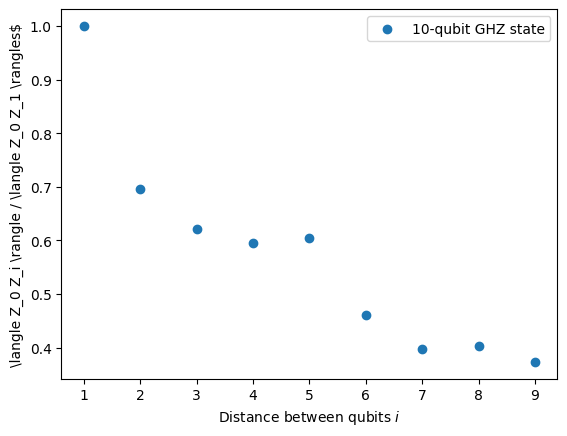

In [14]:
job_id ='d31jdod0qhlc73coomb0'
service = QiskitRuntimeService()
job = service.job(job_id) 
import matplotlib.pyplot as plt

data = list(range(1, len(operators)+1))
result = job.result()[0]
values = result.data.evs
values = [v / values[0] for v in values]

plt.scatter(data, values, marker='o', label='10-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'\langle Z_0 Z_i \rangle / \langle Z_0 Z_1 \rangles$')
plt.legend()
plt.show()
